In [1]:

!pip install jupyter
!python -m pip install --upgrade pip
# 2. Install PyTorch (CPU-only)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# 3. Install NetworkX
!pip install networkx

# 4. Install SciPy
!pip install scipy

# 5. Install Scikit-Learn
!pip install scikit-learn

# 6. Install Matplotlib
!pip install matplotlib

# 7. Install Torch Geometric and its dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.2+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.2+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.2+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.2+cpu.html
!pip install torch-geometric



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html


In [2]:
graph_file = '/Users/evannyhus/Desktop/cmps3340/community_detection/data/com-dblp.ungraph.txt.gz'
top_5000_file ='/Users/evannyhus/Desktop/cmps3340/community_detection/data/com-dblp.top5000.cmty.txt.gz'



In [3]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import gzip
from tqdm import tqdm

# Step 1: Load the graph
def load_graph(file_path):
    G = nx.Graph()
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
    return G

# Step 2: Load top 5000 communities with mapping (ground truth)
def load_top_n_communities_with_mapping(file_path, top_n=100):
    communities = {}
    with gzip.open(file_path, 'rt') as f:
        for i, line in enumerate(tqdm(f, desc="Loading communities")):
            if i >= top_n:
                break
            nodes = list(map(int, line.strip().split()))
            for node in nodes:
                if node not in communities:
                    communities[node] = i  # Assign each node to a single community
    return communities


# Load the graph and ground truth communities
G = load_graph(graph_file)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

top_n = 100  # Adjust this number as needed
top_communities = load_top_n_communities_with_mapping(top_5000_file, top_n=top_n)
print(f"Loaded {len(top_communities)} nodes with their ground truth communities.")

# Filter the graph to only include nodes from the top N communities
filtered_G = G.subgraph(top_communities.keys()).copy()
print(f"Filtered graph: {filtered_G.number_of_nodes()} nodes, {filtered_G.number_of_edges()} edges.")


Graph loaded with 317080 nodes and 1049866 edges.


Loading communities: 100it [00:00, 20459.02it/s]

Loaded 948 nodes with their ground truth communities.
Filtered graph: 948 nodes, 2852 edges.


In [4]:
import sys
print(sys.executable)

/Users/evannyhus/.pyenv/versions/3.11.0/bin/python


In [5]:
import scipy as sp
A = nx.to_scipy_sparse_array(filtered_G).astype(np.float32)


# Generate random node features (replace this with real features if available)
num_nodes = filtered_G.number_of_nodes()
node_features = np.random.rand(num_nodes, 16).astype(np.float32)  # 16 dim random features

print(f"Adjacency Matrix Shape: {A.shape}")
print(f"Node Features Shape: {node_features.shape}")

Adjacency Matrix Shape: (948, 948)
Node Features Shape: (948, 16)


In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import scipy.sparse as sp
# from torch import SparseTensor
import networkx as nx

class GNN(torch.nn.Module):
  def __init__(self, num_features, hidden_channels, num_communities, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels * 2, cached=True)
        self.conv2 = GCNConv(hidden_channels * 2, hidden_channels, cached=True)
        self.linear = torch.nn.Linear(hidden_channels, num_communities)
        self.dropout = dropout

        # Add batch normalization layers
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * 2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

  def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Add batch norm after conv
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Add batch norm after conv
        x = F.relu(x)

        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [24]:
from sklearn.preprocessing import StandardScaler

def compute_node_features(adj_matrix):
    """
    Compute enhanced but focused set of structural node features
    """
    G = nx.from_scipy_sparse_array(adj_matrix)

    # Your current features
    degrees = np.array([d for n, d in G.degree()])
    clustering = np.array(list(nx.clustering(G).values()))
    pagerank = np.array(list(nx.pagerank(G).values()))

    # Add these new features
    core_numbers = np.array(list(nx.core_number(G).values()))
    avg_neighbor_degree = np.array(list(nx.average_neighbor_degree(G).values()))

    # Create feature interactions (can be very powerful for community detection)
    degree_clustering = degrees * clustering  # High values indicate dense local neighborhoods
    relative_degree = degrees / (avg_neighbor_degree + 1)  # Relative importance in local neighborhood

    features = np.column_stack([
        degrees,
        clustering,
        pagerank,
        core_numbers,
        avg_neighbor_degree,
        degree_clustering,
        relative_degree
    ])

    # Use StandardScaler instead of manual normalization
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return torch.FloatTensor(features)

def evaluate(model, data, mask):
    """
    Evaluate model performance on the masked nodes
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        return float(correct.sum()) / float(mask.sum())


def prepare_sparse_data(adj_matrix, labels, node_features):
    # build edge_index once
    edge_index = torch.from_numpy(
        np.vstack(adj_matrix.nonzero())
    ).long()
    # if node_features is already a Tensor, leave it; otherwise convert
    if isinstance(node_features, torch.Tensor):
        x = node_features
    else:
        x = torch.from_numpy(node_features).float()
    y = torch.from_numpy(labels).long()
    return Data(x=x, edge_index=edge_index, y=y)







In [25]:
def train_model_with_early_stopping(model, data, patience=10, num_epochs=200, batch_size=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    # Split indices for training and validation
    num_nodes = data.x.size(0)
    indices = torch.randperm(num_nodes)
    train_idx = indices[:int(0.8 * num_nodes)]
    val_idx = indices[int(0.8 * num_nodes):]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    data.train_mask = train_mask
    data.val_mask = val_mask

    model.train()
    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])

            if (epoch + 1) % 5 == 0:
                train_acc = evaluate(model, data, data.train_mask)
                val_acc = evaluate(model, data, data.val_mask)
                print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = {key: value.cpu().detach()
                         for key, value in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_state)
                break

    return model

def predict_communities_batch(model, data, batch_size=1000):
    model.eval()
    predictions = []

    for i in range(0, data.x.size(0), batch_size):
        batch_end = min(i + batch_size, data.x.size(0))
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            batch_pred = out[i:batch_end].argmax(dim=1)
            predictions.append(batch_pred)

    return torch.cat(predictions).numpy()

In [26]:
# Convert one-hot encoded labels to class indices
labels = np.array([top_communities[node] for node in filtered_G.nodes()])
node_features = compute_node_features(A)
print(f"Node Features Shape: {node_features.shape}")

# Prepare the data
data = prepare_sparse_data(A, labels, node_features)


Node Features Shape: torch.Size([948, 7])


In [28]:


# Initialize the model with appropriate dimensions
model = GNN(
    num_features=7,  # 5 structural features: node degrees, clustering coefficient, pagerank, core_numbers, avg_neighbor_degree
    hidden_channels=512,  # Increased for better representation
    num_communities=top_n,  # Your number of communities
    dropout=0.4
)


# Train the model with early stopping
model = train_model_with_early_stopping(model, data,
                                      patience=50,
                                      num_epochs=500)

Epoch 005, Loss: 3.4325, Val Loss: 4.4456, Train Acc: 0.0976, Val Acc: 0.0789
Epoch 010, Loss: 2.9079, Val Loss: 4.3059, Train Acc: 0.0660, Val Acc: 0.0632
Epoch 015, Loss: 2.5597, Val Loss: 4.1449, Train Acc: 0.0673, Val Acc: 0.0684
Epoch 020, Loss: 2.2810, Val Loss: 4.0394, Train Acc: 0.0475, Val Acc: 0.0632
Epoch 025, Loss: 2.0728, Val Loss: 4.0422, Train Acc: 0.0409, Val Acc: 0.0526
Epoch 030, Loss: 1.8970, Val Loss: 4.0377, Train Acc: 0.0554, Val Acc: 0.0684
Epoch 035, Loss: 1.7735, Val Loss: 3.8927, Train Acc: 0.0937, Val Acc: 0.0895
Epoch 040, Loss: 1.6734, Val Loss: 3.5659, Train Acc: 0.1161, Val Acc: 0.1158
Epoch 045, Loss: 1.5897, Val Loss: 3.1427, Train Acc: 0.1517, Val Acc: 0.1632
Epoch 050, Loss: 1.5298, Val Loss: 2.6702, Train Acc: 0.2098, Val Acc: 0.2158
Epoch 055, Loss: 1.4704, Val Loss: 2.2633, Train Acc: 0.3008, Val Acc: 0.2947
Epoch 060, Loss: 1.4284, Val Loss: 1.9440, Train Acc: 0.4063, Val Acc: 0.4158
Epoch 065, Loss: 1.3952, Val Loss: 1.7326, Train Acc: 0.5224, Va

In [ ]:
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    f1_score
)

def evaluate_clustering(true_labels, predicted_labels):
    """
    Evaluate clustering performance using NMI, ARI, ACC, and F1 scores.
    """
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)

    # Calculate accuracy
    acc = np.sum(true_labels == predicted_labels) / len(true_labels)

    # Calculate F1 score (macro-averaged for multi-class case)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    return {'NMI': nmi, 'ARI': ari, 'ACC': acc, 'F1': f1}


In [ ]:
# Make predictions
predicted_communities = predict_communities_batch(model, data)

In [ ]:
# Evaluate results
metrics = evaluate_clustering(labels, predicted_communities)
print(f"NMI Score: {metrics['NMI']:.4f}")
print(f"ARI Score: {metrics['ARI']:.4f}")
print(f"Accuracy: {metrics['ACC']:.4f}")
print(f"F1 score: {metrics['F1']:.4f}")




NMI Score: 0.9161
ARI Score: 0.5661
Accuracy: 0.7824
F1 score: 0.5242


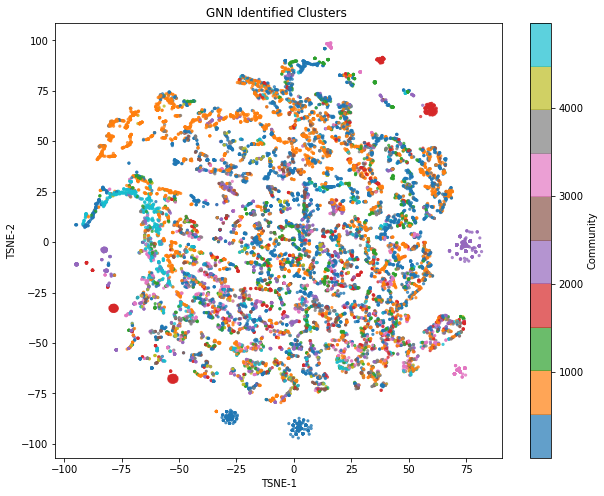

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_clusters(embeddings, labels, title='Cluster Visualization'):
    # Reduce dimensionality to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=labels, cmap='tab10', s=5, alpha=0.7
    )
    plt.colorbar(scatter, label='Community')
    plt.title(title)
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.show()

# Use the trained model to generate embeddings
node_embeddings = model(data.x, data.edge_index).detach().numpy()

# Visualize the predicted clusters
visualize_clusters(node_embeddings, predicted_communities, title='GNN Identified Clusters ')
